# Imports

In [15]:
# CapyMoa
from capymoa.datasets import Electricity, ElectricityTiny
from capymoa.evaluation import prequential_evaluation, prequential_evaluation_multiple_learners
from capymoa.classifier import OnlineBagging, HoeffdingTree, KNN
from capymoa.evaluation.visualization import plot_windowed_results

# River
from river.evaluate import progressive_val_score, iter_progressive_val_score
from river.metrics import Accuracy
from river.metrics.base import Metrics
from river.utils import Rolling

from river.tree import HoeffdingTreeClassifier
from river.ensemble import BaggingClassifier
from river.neighbors import KNNClassifier
from river import metrics


# Miscellaneous for tracking
import time, tracemalloc, psutil
import matplotlib.pyplot as plt

# Utils

In [ ]:
# Generator to yield (x_dict, y) in river format
def capymoa_to_river_stream(stream):
    feature_names = stream.get_schema().get_numeric_attributes()
    for instance in stream:
        x_dict = dict(zip(feature_names, instance.x))
        y = instance.y_index  # or instance.y if using class label
        yield x_dict, y

# Start measurements
def start_measurements():
    tracemalloc.start()
    start_time = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    return start_time, cpu_start

def end_measurements():
    end_time = time.time()
    cpu_end = psutil.cpu_percent(interval=None)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return end_time, cpu_end, current, peak

# Function to plot the results
def plot_results(results, plot_title):
    # Print results for each learner
    for name, scores in results.items():
        rmse_values = [score['Accuracy'].get() for score in scores]
        steps = [score['Step'] for score in scores]  
        plt.plot(steps, rmse_values, label=name)

    plt.xlabel("Instance")
    plt.ylabel("Metric")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()

# CapyMOA


--- Performance Summary ---
Total Time: 5.51 seconds
CPU Usage: 24.5%
Peak Memory Usage: 0.02 MB


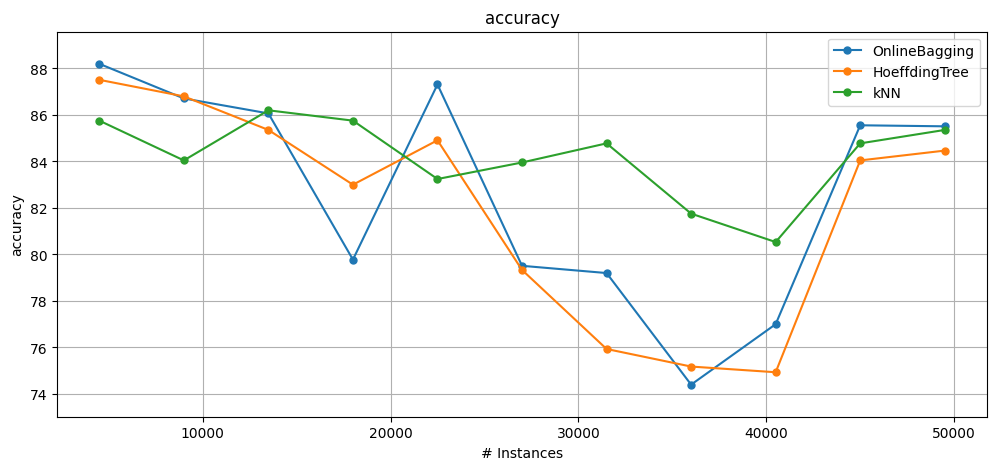

In [ ]:
stream = Electricity()

# Define the learners + an alias (dictionary key)
learners = {
    "HT": HoeffdingTree(schema=stream.get_schema()),
    "KNN": KNN(schema=stream.get_schema(), k=3),
}

start_time, cpu_start = start_measurements()

results = {name: [] for name in learners.keys()}
for name, learner in learners.items():
    result = prequential_evaluation(stream=stream, learner=learner, window_size=4500)
    results[name] = result


end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

plot_windowed_results(results["OB"], results["HT"], results['KNN'],  metric="accuracy")

## Multiple Learners functionality in CapyMOA


--- Performance Summary ---
Total Time: 16.57 seconds
CPU Usage: 20.3%
Peak Memory Usage: 0.10 MB


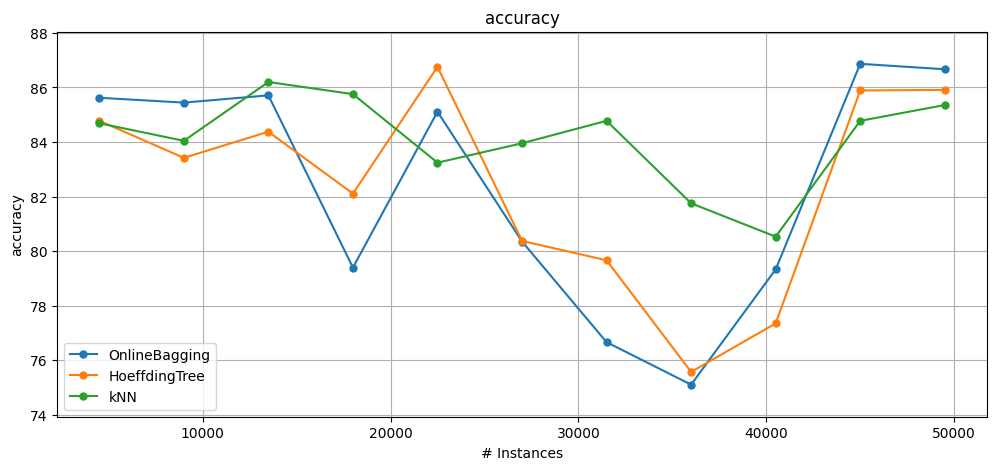

In [ ]:
stream = Electricity()

start_time, cpu_start = start_measurements()

results = prequential_evaluation_multiple_learners(stream, learners, window_size=4500)

end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

plot_windowed_results(results["OB"], results["HT"], results['KNN'],  metric="accuracy")

# River

In [ ]:
# Model for bagging 
model=HoeffdingTreeClassifier()

# Define the learners
learners = {
    "HT": HoeffdingTreeClassifier(),
    "KNN": KNNClassifier(n_neighbors=3),
}

# Create a prequential evaluation loop for multiple learners
results = { name: [] for name in learners }

start_time, cpu_start = start_measurements()

for name, model in learners.items():
    # Convert CapyMoa stream to River
    stream = capymoa_to_river_stream(Electricity())

    # Define a metric
    metric = Metrics(metrics=[Accuracy()])
    steps_score = list(iter_progressive_val_score(dataset=stream, model=model, metric=metric, step=500))
    results[name] = steps_score

end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {(end_time - start_time) / 60 :.2f} minutes")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

# Print results for each learner
for name, accs in results.items():
    print(f"Accuracy for {name}: {accs[-1]}")


--- Performance Summary ---
Total Time: 2.57 minutes
CPU Usage: 22.3%
Peak Memory Usage: 17.02 MB
Accuracy for HT: {'Accuracy': Accuracy: 59.13%, 'Step': 2000}
Accuracy for KNN: {'Accuracy': Accuracy: 53.98%, 'Step': 2000}
